# Lab 03: Exploring CFIR Image Data

Erik Gabrielsen, Danh Nguyen

## Business Understanding 

Human beings are very adept at recognizing objects and patterns in images, but the same cannot be said about computers. As we push forward in the field of computer vision, the [CFIR-10](https://www.kaggle.com/c/cifar-10) dataset was used in a Kaggle competition to programatically recognize objects in images. The dataset consists of 50,000 training images with the following labels: 

* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

The images are 32x32, colored with the subject mostly centered in the middle of the image. Their subjects are various types, shapes, and orientations. For instance, birds and cats can be of different species and sizes, and images of truck can be taken head on, from behind, or from the side. The dataset also contains 10,000 test images to classify for the competition, as well as 290,000 "junk" images that are not scored.  

In the first lab, we will explore certain component analysis and feature extraction to see if there are common differences among the classes. The ultimate goal is to programmatically determine what type of object appears in an image. We hope to achieve above 50% accuracy on our training and testing sets one day. In the interest of runtime, we will look at the 5,000 images of the training set. In these first images, the distribution of images per label is pretty even at around 500 images each.  


In [2]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns

%matplotlib inline



In [3]:
directory = os.path.expanduser('~/Downloads/train/')
images = []
files = []

# loop over directories: 
for i in range(1, 50001):
    name = str(i) + '.png'
    file = os.path.join(directory, name)
    images.append(mpimg.imread(file))

In [4]:
# Read in label
df = pd.read_csv('~/Downloads/trainLabels.csv') # read in the csv file
labels = df.label.values

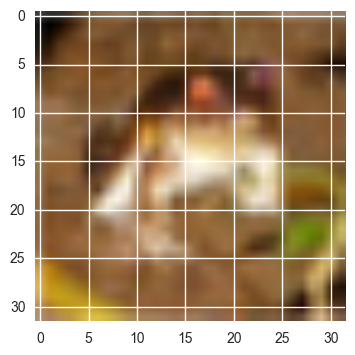

In [5]:
imgplot = plt.imshow(images[0])

## Data Preparation 

The images are initially stored as 3 separate matrices for Red, Green, and Blue values. We converted these 3 matrices into 1 grayscale image according to the luminance formula: `0.299*R + 0.587*G, 0.114*B`. Examples of the grayscale images are displayed below. 

In [6]:
# convert to luminance, thanks http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

for i in range(0, len(images)):
    images[i] = rgb2gray(images[i])

In [7]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


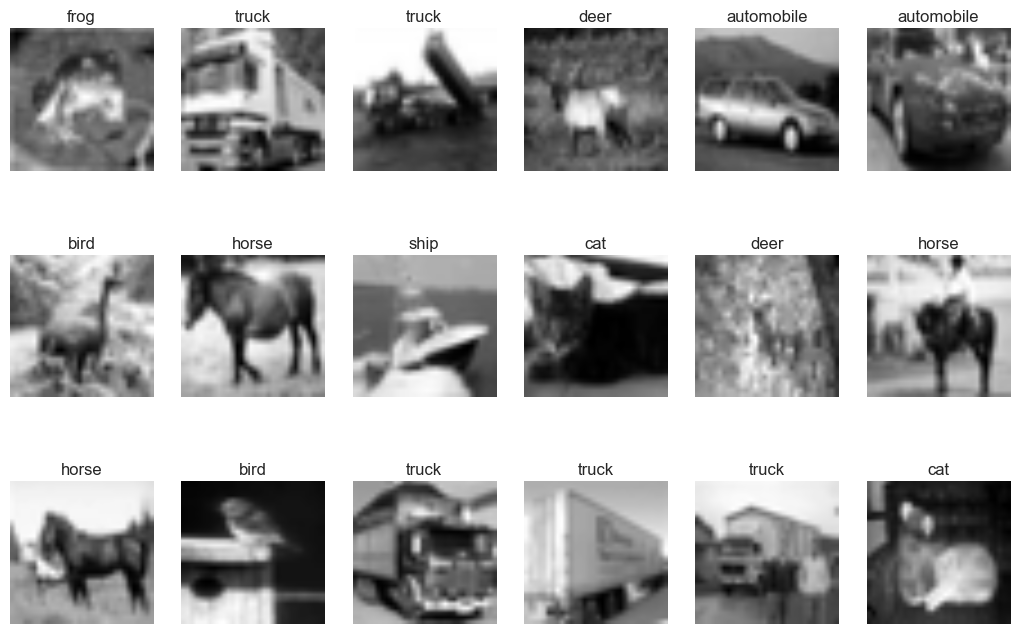

In [8]:
plot_gallery(images, labels, 32, 32) # defaults to showing a 3 by 6 subset of the faces

In [9]:
# Linearization
img_concat = []
for image in images: 
    img_concat.append(np.concatenate(image))

In [10]:
# img_concat_arr = np.array(img_concat)
print(len(img_concat))
print(np.array(img_concat[0:50000]).shape)

50000
(50000, 1024)


We then concatenate each image matrix to represent it as one linear array of image features. As previously stated, we are looking at only 5,000 images in order to save time running analysis and feature extraction algorithms. 

In [11]:
# get some of the specifics of the dataset
# y = lfw_people.target
X = np.array(img_concat[0:5000]) 
names = labels[0:5000]

n_samples, n_features = X.shape
h, w = 32, 32
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {}by{}".format(h,w))
print (125*94) # the size of the images are the size of the feature vectors

n_samples: 5000
n_features: 1024
n_classes: 5000
Original Image Sizes 32by32
11750


## Full PCA

In [12]:
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenobjects from %d objects" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenobjects from 5000 objects
CPU times: user 2.66 s, sys: 100 ms, total: 2.76 s
Wall time: 1.49 s


In [13]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [ ]:
plot_explained_variance(pca)

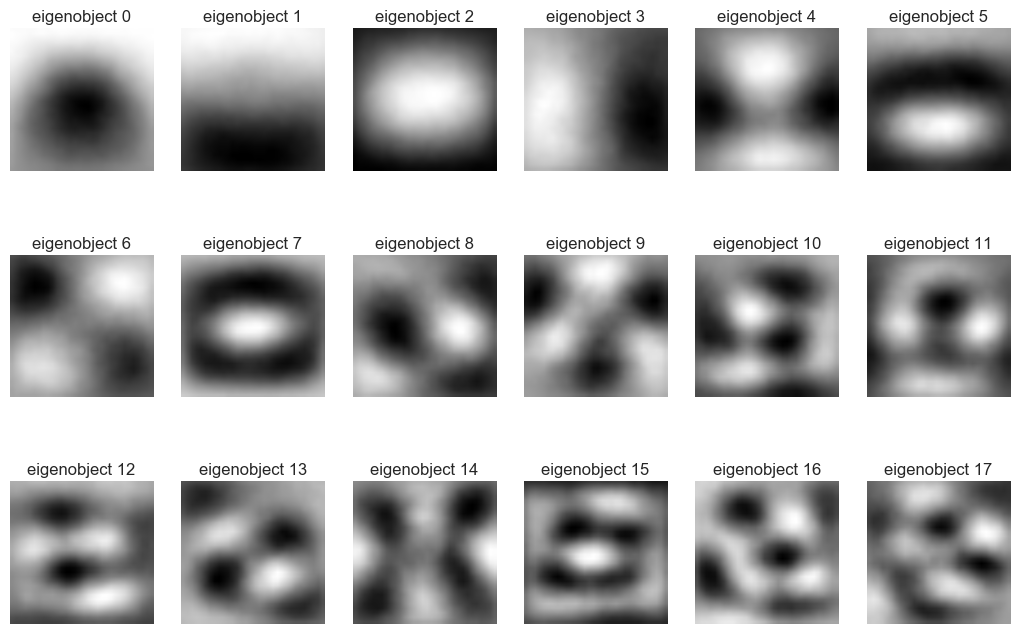

In [15]:
eigen_titles = ["eigenobject %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigen_titles, h, w)

In [16]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



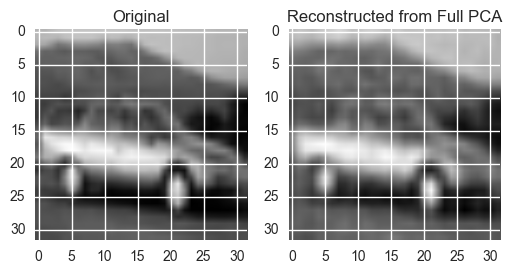

In [17]:
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[4].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')

## Randomized PCA

In [18]:
from sklearn.decomposition import RandomizedPCA

n_components = 300
print ("Extracting the top %d eigenvalues from %d objects" % (
    n_components, X.shape[0]))

rpca = RandomizedPCA(n_components=n_components)
%time rpca.fit(X)
eigenfaces = rpca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenvalues from 5000 objects
CPU times: user 1.44 s, sys: 101 ms, total: 1.54 s
Wall time: 863 ms


In [ ]:
plot_explained_variance(rpca)

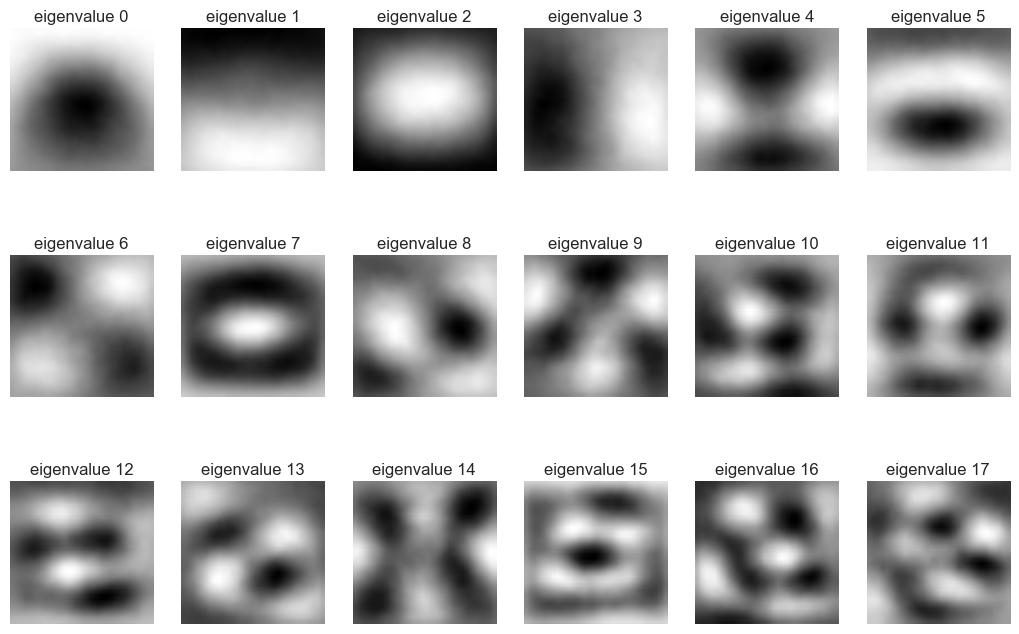

In [19]:
eigenface_titles = ["eigenvalue %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



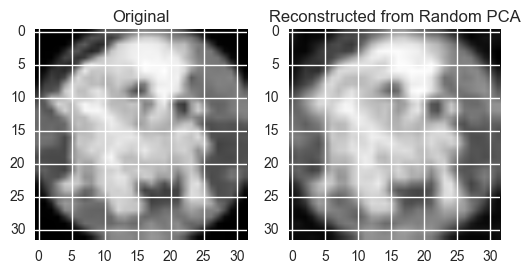

In [20]:
from skimage.io import imshow
idx_to_reconstruct = int(np.random.rand(1)*len(X))
low_dimensional_representation, reconstructed_image = reconstruct_image(rpca,X[idx_to_reconstruct])
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Random PCA')


## Kernel PCA- Nonlinear Reduction

In [21]:
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(X)


Extracting the top 300 eigenfaces from 5000 faces
CPU times: user 37.1 s, sys: 1.09 s, total: 38.2 s
Wall time: 22.1 s


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300,
     remove_zero_eig=False, tol=0)

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



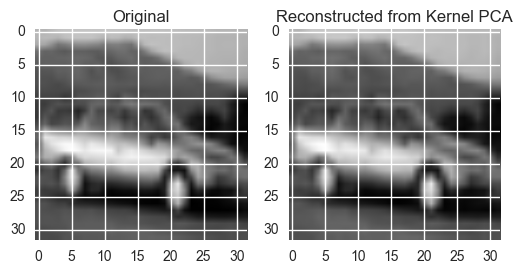

In [22]:
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(kpca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[4].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Kernel PCA')

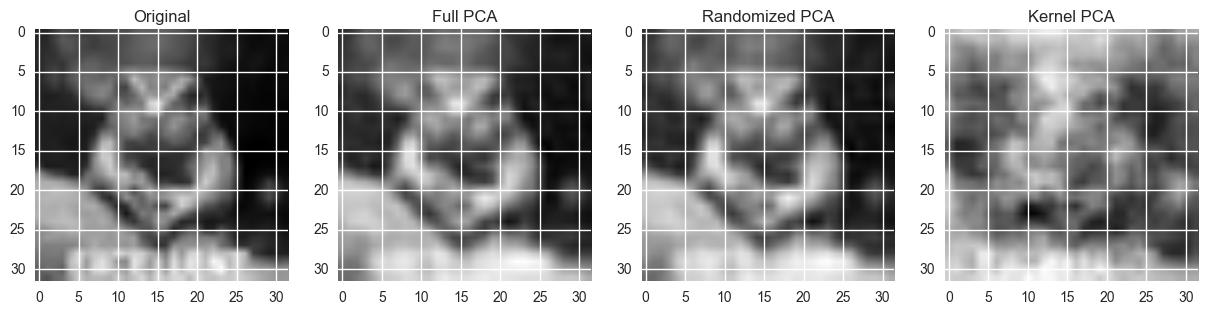

In [24]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

## Feature Extraction

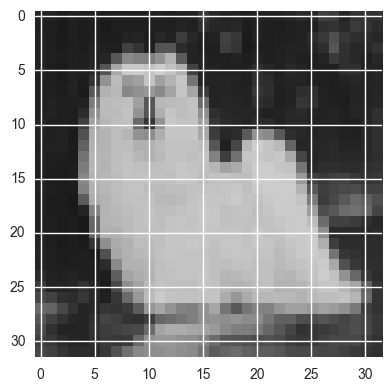

In [25]:
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)

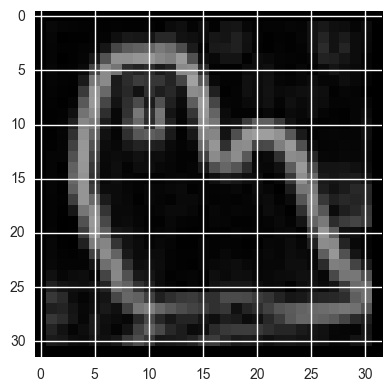

In [26]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)

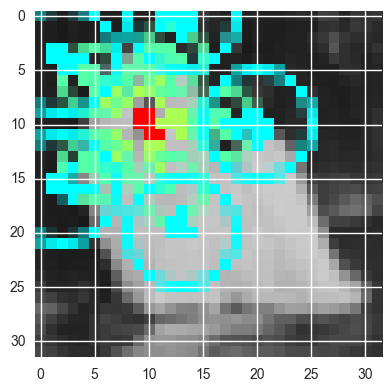

In [27]:
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)

In [28]:
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(2, 2, 72)
288


In [29]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

CPU times: user 6.96 ms, sys: 3.64 ms, total: 10.6 ms
Wall time: 7.27 ms


(416,)

In [30]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 15.6 s, sys: 123 ms, total: 15.7 s
Wall time: 16.1 s
(5000, 416)


In [31]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features,n_jobs=-1)

CPU times: user 614 ms, sys: 10 s, total: 10.7 s
Wall time: 11.9 s


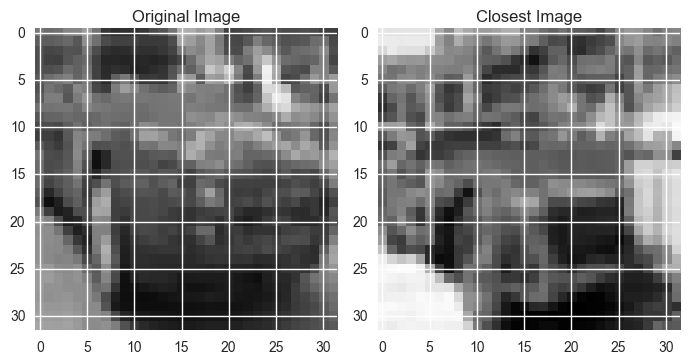

In [32]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")

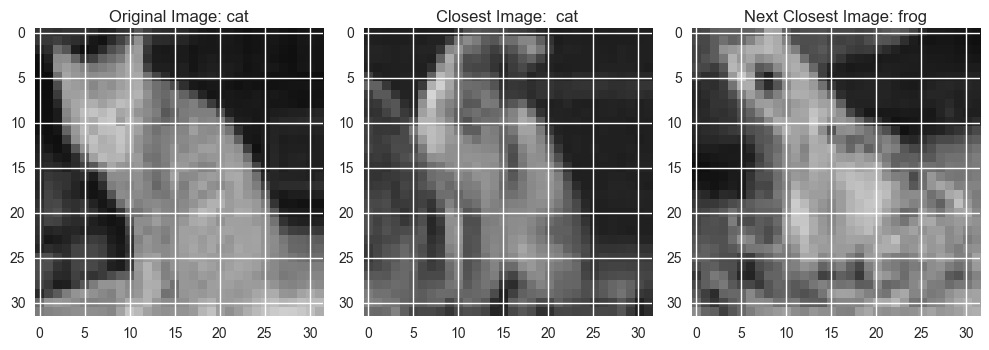

In [33]:
from ipywidgets import fixed
from ipywidgets import widgets
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Original Image: "+names[idx1])

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image:  "+names[idx2])
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image: "+names[idx3])
    
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

## Gabor Feature Extraction

In [34]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature

array([  4.87893575e-01,   3.39481654e-02,  -1.64998622e-01,
        -6.46851510e-01,   1.49151701e-01,   5.09055742e-03,
        -4.75884601e-01,  -3.55571754e-01,   3.29117297e-01,
         8.03397823e-03,   2.39092844e-01,  -9.80810912e-01,
         4.90920938e-04,   3.48010016e-04,   1.71260205e-02,
         3.13899414e+00,   4.87897904e-01,   3.39953193e-02,
        -1.65485163e-01,  -6.40499100e-01,   1.49360660e-01,
         4.79448524e-03,  -4.08586431e-01,  -4.19356851e-01,
         3.31967454e-01,   8.83215369e-03,   2.88480652e-01,
        -9.33495917e-01,   7.90691508e-05,   6.73552521e-05,
         8.15130352e-02,   4.85363867e-01,   4.87893575e-01,
         3.40513144e-02,  -1.64974342e-01,  -6.40012509e-01,
         1.49151701e-01,   5.22253924e-03,  -4.71227350e-01,
        -2.01583188e-01,   3.29117297e-01,   1.03035074e-02,
         2.86417501e-01,  -9.11662293e-01,   4.90920938e-04,
         3.89763034e-04,  -1.18372554e-02,   4.45852501e-01,
         4.87897904e-01,

In [35]:
# takes ~3 minutes to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

CPU times: user 1min 46s, sys: 2.57 s, total: 1min 48s
Wall time: 1min 50s
(5000, 64)


In [36]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats,n_jobs=-1)

CPU times: user 470 ms, sys: 9.51 s, total: 9.98 s
Wall time: 11.3 s


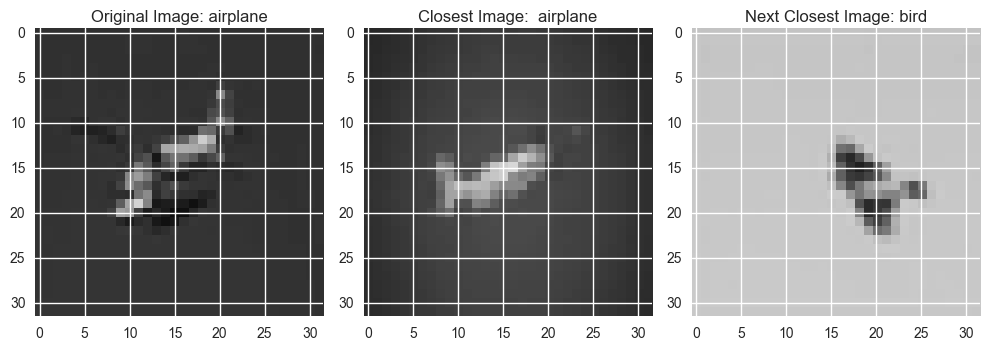

In [37]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

## Comparing Gabor Features

In [39]:
cols = np.arange(0, 66, 1)
col_vector = np.array(names)
# create column vector and add it to matrix with label
cols_test = np.column_stack((col_vector,col_vector))
gabor = np.hstack((gabor_stats, cols_test))
df = pd.DataFrame(gabor, columns=cols)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.414985,0.0151873,0.997814,1.33958,0.126863,0.0022937,0.901147,1.51329,0.279936,0.0033493,...,0.28236,0.00369319,0.988361,0.771068,6.72534e-05,4.94922e-05,0.00646399,0.240914,frog,frog
1,0.486309,0.0311803,0.266083,-0.726545,0.148667,0.0043284,0.222907,-0.751098,0.328048,0.006347,...,0.330889,0.0077034,-0.0312266,-0.951356,7.88123e-05,7.97332e-05,0.0455811,-0.0215064,truck,truck
2,0.501356,0.0796952,0.506289,-1.30794,0.153267,0.00847415,0.454683,-1.33252,0.338198,0.023858,...,0.341127,0.0274241,0.467073,-1.19327,8.12509e-05,0.000130121,0.0302848,2.26077,truck,truck
3,0.318379,0.0103046,1.80502,3.89084,0.0973301,0.00138853,1.46852,3.05466,0.214768,0.0024342,...,0.216628,0.0025535,1.53392,2.27188,5.15972e-05,1.86769e-05,0.0422627,1.37379,deer,deer
4,0.376304,0.0309635,0.413068,-0.368363,0.115038,0.00380832,0.298167,-0.21173,0.253843,0.00474758,...,0.256041,0.00671076,0.38166,-0.585259,6.09848e-05,9.77567e-05,-0.026744,3.88174,automobile,automobile


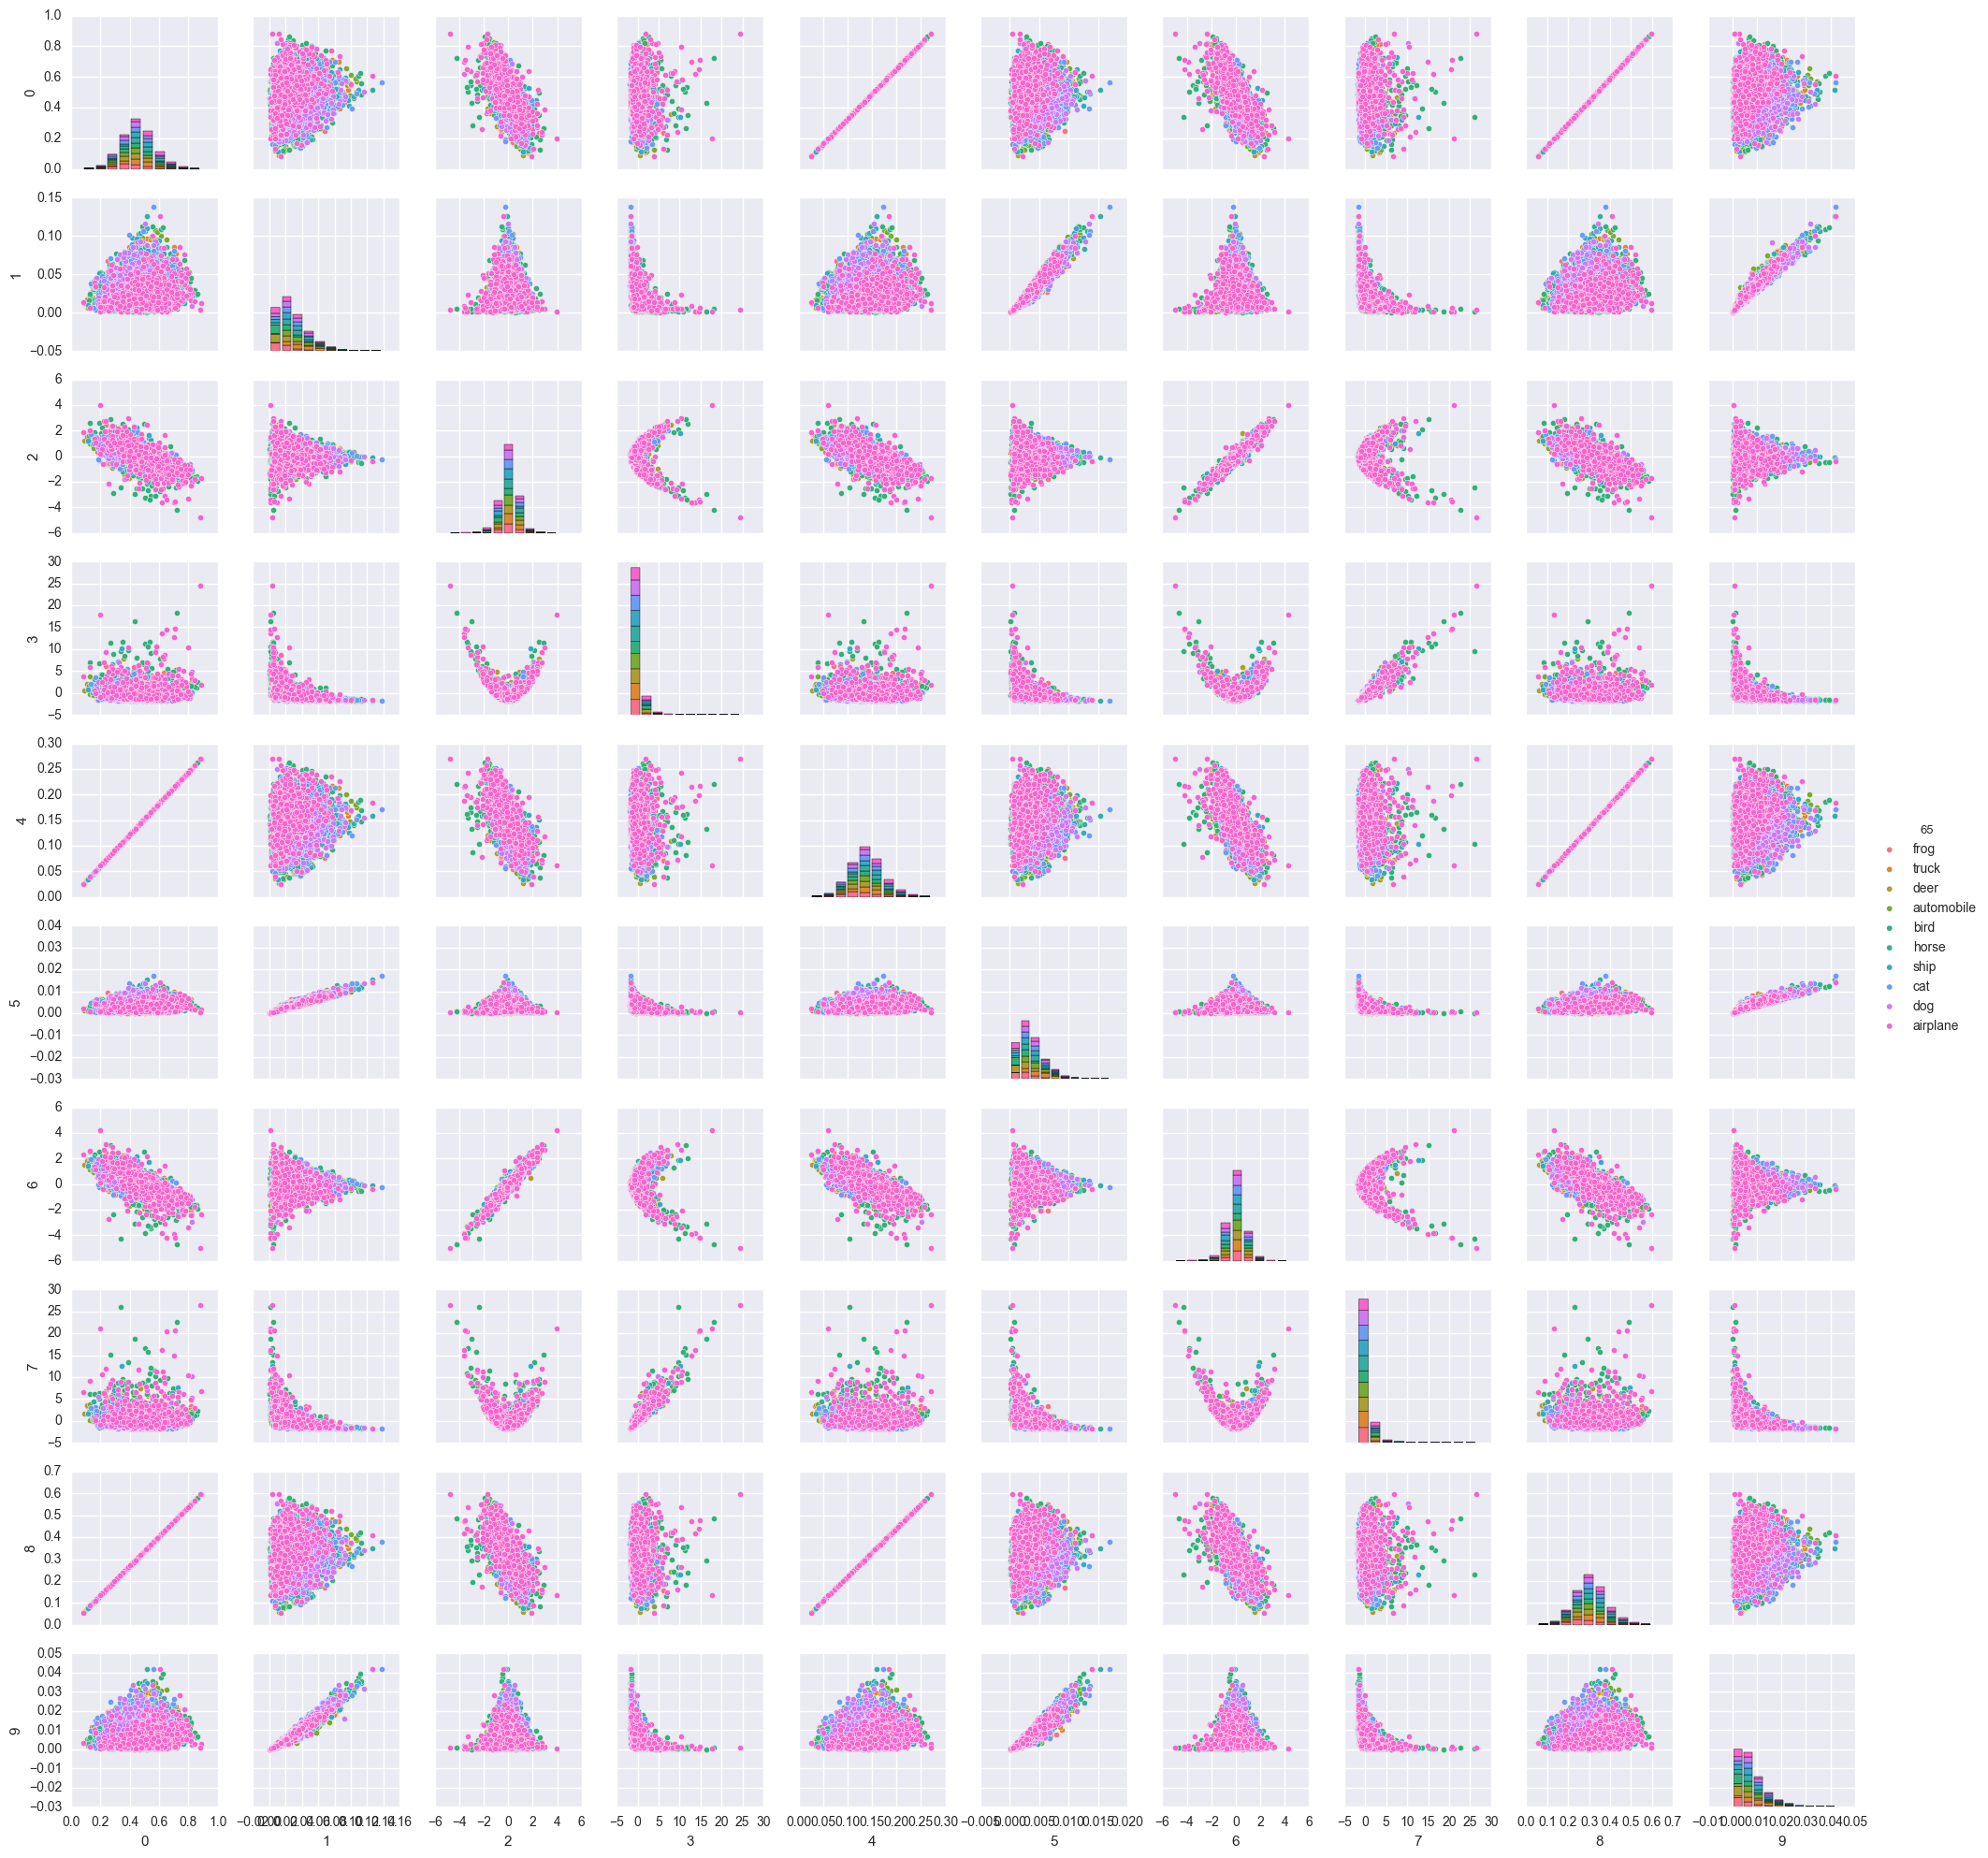

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

deleted_cols = np.arange(10,65,1)

#only use the top 10 gabor values in feature pair plots
df.drop(df.columns[deleted_cols], axis=1, inplace=True)
df.head()
sns.set()
sns.pairplot(df,hue=65, size=2)

In [41]:
# get dataframes for truck and bird for comparison
df_copy = df.copy()
df_truck = df_copy[df_copy[65] == 'truck']

df_copy = df.copy()
df_frog = df_copy[df_copy[65] == 'bird']
df_frog.head()


,0,1,2,3,4,5,6,7,8,9,65
6,0.505732,0.0173553,-0.15774,-0.679333,0.154605,0.00258286,-0.302882,-0.50391,0.34115,0.00430658,bird
13,0.279947,0.0577793,0.94799,-0.487866,0.0855814,0.0065231,0.957465,-0.480187,0.188843,0.0126591,bird
18,0.47897,0.0406575,0.159828,-1.53493,0.146424,0.00468858,0.0934428,-1.49384,0.323097,0.0121065,bird
24,0.328494,0.0127476,0.0936351,0.659005,0.100422,0.00239048,0.49492,0.52727,0.221591,0.00240175,bird
41,0.713186,0.0194525,-2.43579,5.3265,0.218025,0.00409844,-2.79222,7.24887,0.481092,0.00496514,bird


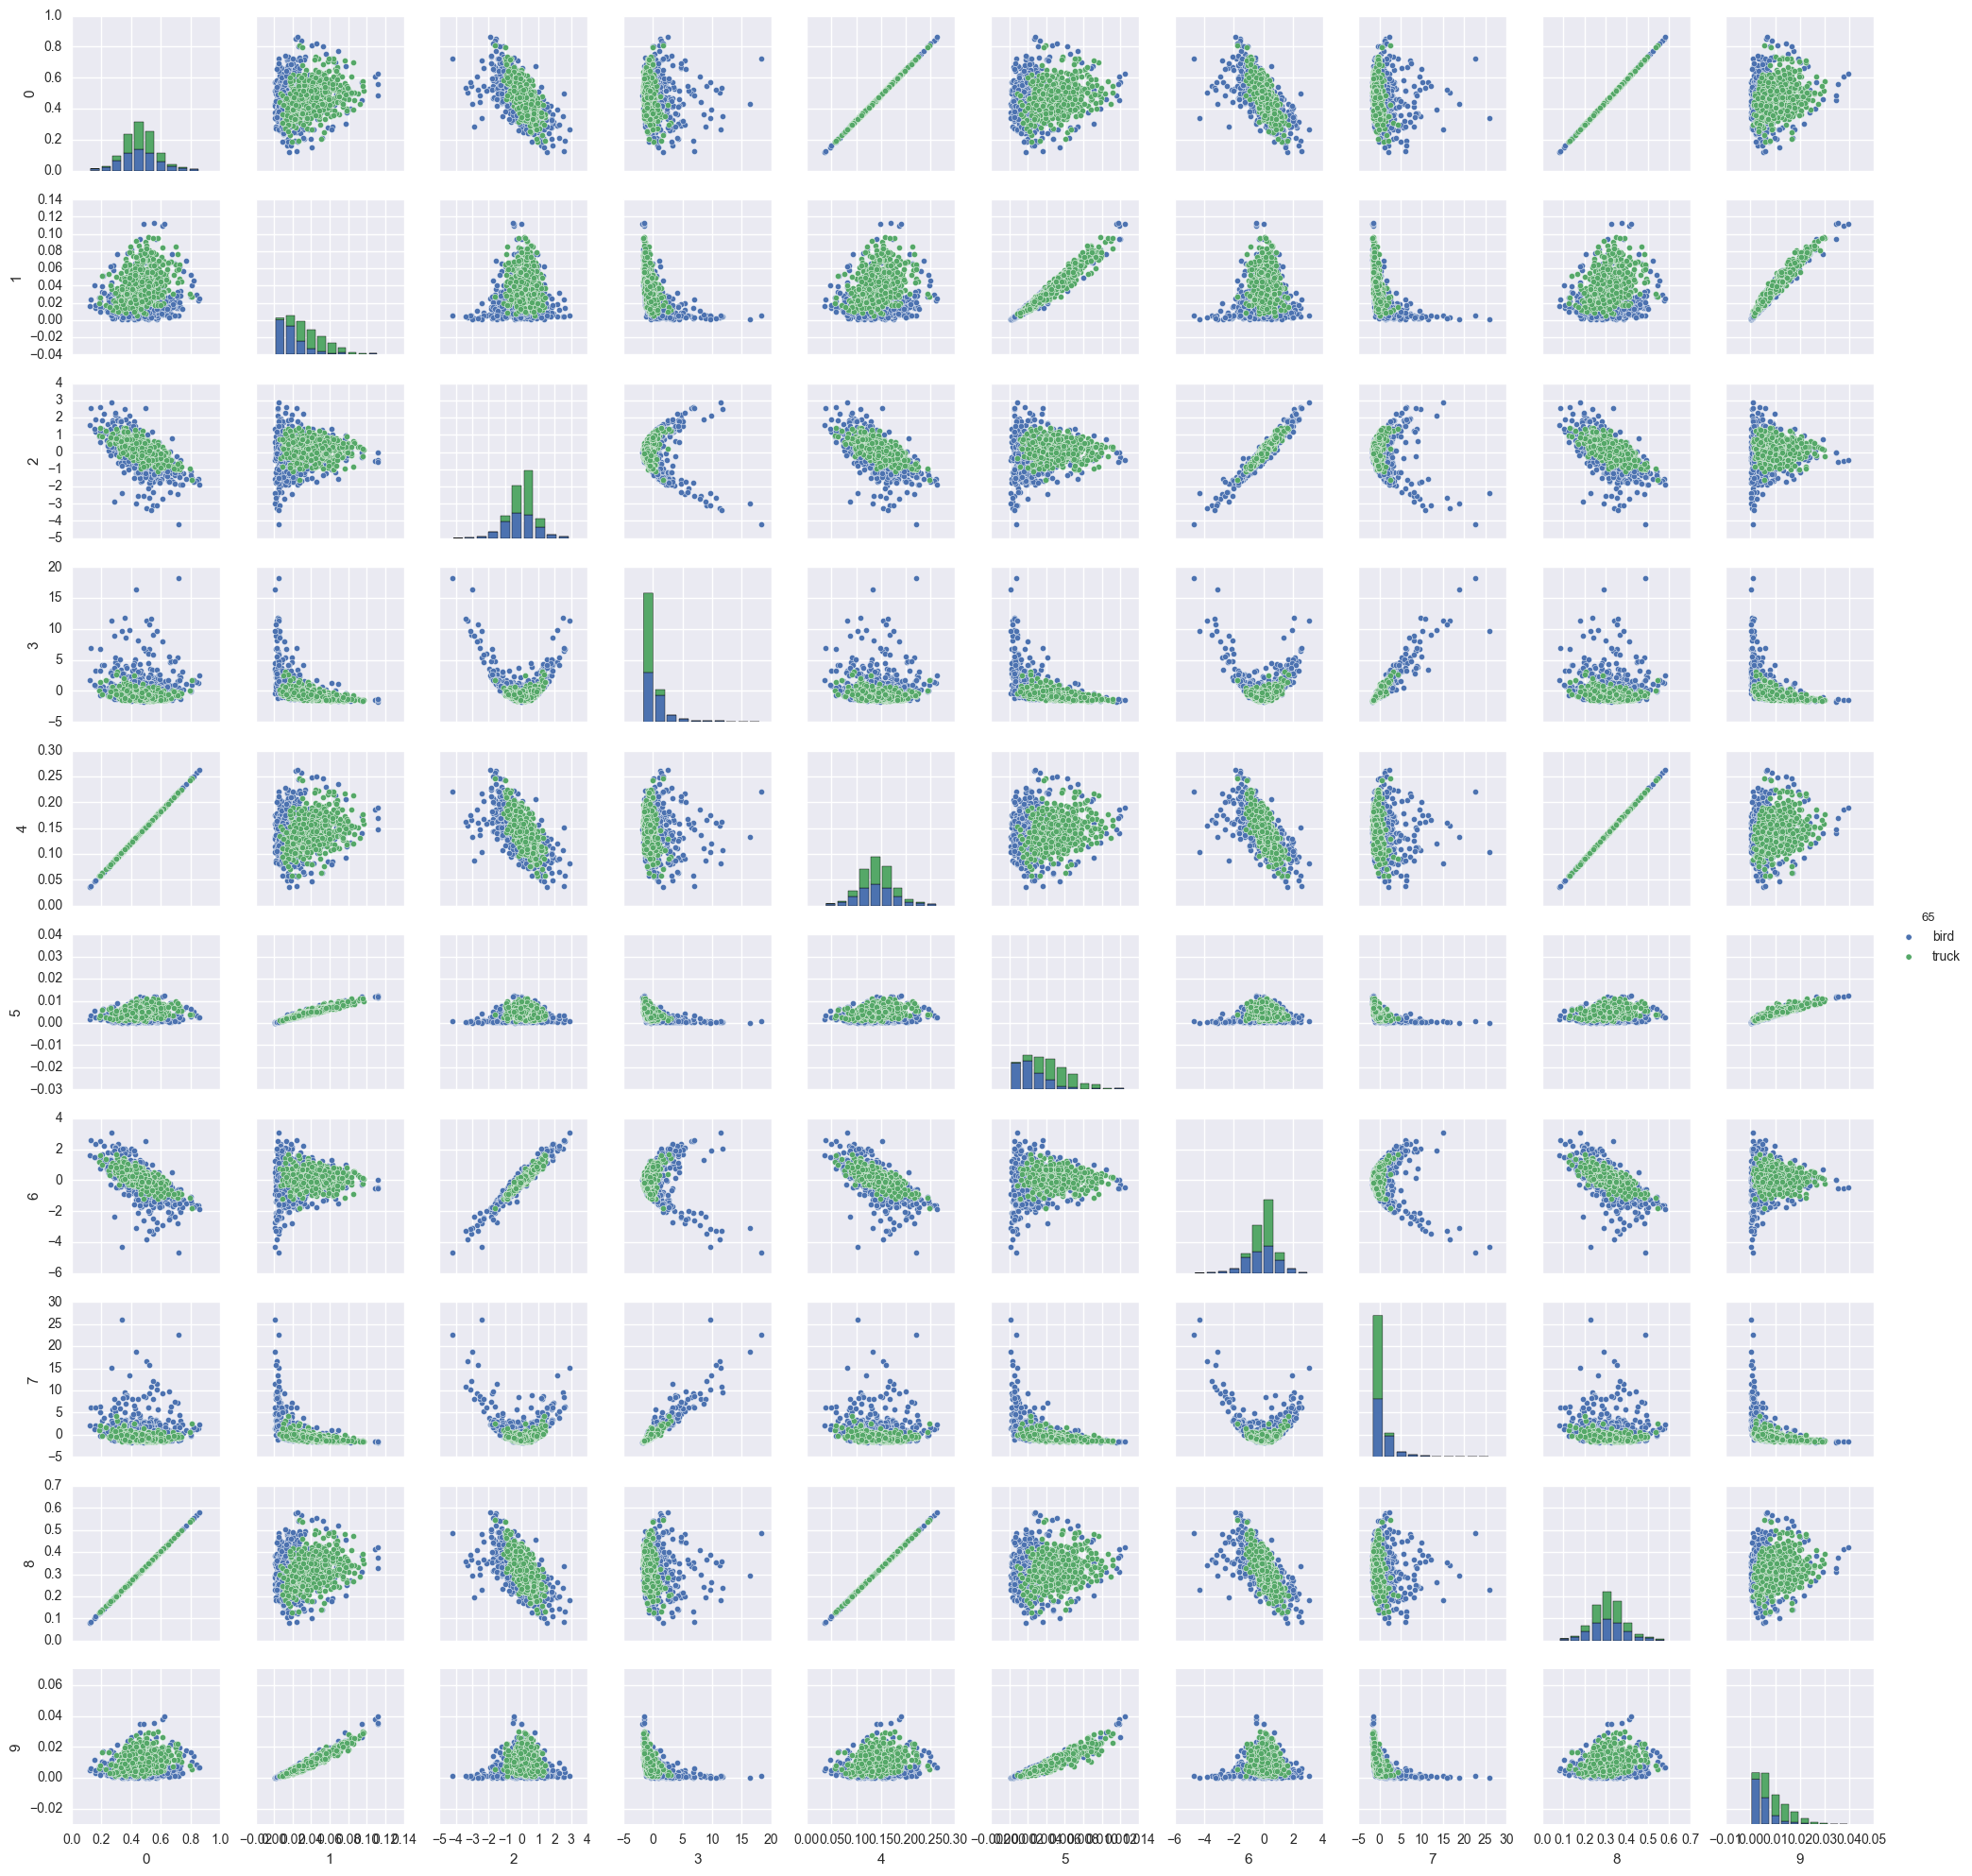

In [42]:
bigdata = df_frog.append(df_truck, ignore_index=True)

sns.set()
sns.pairplot(bigdata,hue=65, size=2)

In [44]:
def biplot(pca, dat, title=''):
    
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    # 0,1 denote PC1 and PC2; change values for other PCs
    xvector = pca.components_[0] 
    yvector = pca.components_[1]

    tmp = pca.transform(dat.values)
    xs = tmp[:,0] 
    ys = tmp[:,1]

    annotations = [Scatter(x=xs, y=ys, mode ='markers', name='cumulative explained variance')]
    for i in range(len(xvector)):
        txt = list(dat.columns.values)[i]
        annotations.append(
                Scatter(
                    x=[0, xvector[i]*max(xs)],
                    y=[0, yvector[i]*max(ys)],
                    mode='lines+text',
                    text=['', txt],
                    name=txt,
                ))
    
    plotly.offline.iplot({
        "data": annotations,
        "layout": Layout(xaxis=XAxis(title='Principal Component One'), 
                         yaxis=YAxis(title='Principal Component Two'),
                        title=title)
    })


    plt.show()
    
X = gabor_stats
pca = PCA(n_components=4)
pca.fit(X) 
columns = np.arange(0,64,1)


In [ ]:
biplot(pca,pd.DataFrame(gabor_stats,columns=columns),'Object Biplot')

In [74]:
target = pd.DataFrame(labels[:5000], np.array(range(0, 5000)))

In [79]:
target = {'labels': labels[:5000], 'id': np.array(range(0, 5000))}

In [80]:
target = pd.DataFrame(target)

In [98]:
target[target['labels']=='frog'].id.values

array([   0,   19,   22,   23,   25,   72,   95,  103,  104,  117,  124,
        125,  132,  143,  151,  154,  164,  187,  200,  204,  209,  210,
        224,  228,  231,  232,  234,  235,  242,  243,  245,  248,  249,
        286,  292,  298,  313,  326,  327,  347,  350,  351,  355,  361,
        368,  387,  409,  437,  451,  452,  464,  473,  488,  525,  529,
        532,  552,  556,  571,  587,  588,  591,  619,  620,  625,  633,
        640,  645,  651,  655,  667,  680,  682,  692,  710,  718,  720,
        721,  728,  738,  745,  755,  770,  781,  807,  818,  819,  836,
        837,  838,  854,  862,  863,  896,  899,  903,  914,  920,  921,
        923,  929,  931,  935,  937,  960,  961,  985, 1013, 1016, 1017,
       1023, 1027, 1031, 1035, 1038, 1047, 1051, 1053, 1063, 1085, 1101,
       1126, 1131, 1132, 1154, 1155, 1159, 1161, 1175, 1176, 1191, 1192,
       1194, 1210, 1220, 1222, 1228, 1237, 1246, 1248, 1259, 1317, 1318,
       1327, 1342, 1360, 1362, 1367, 1371, 1374, 13

In [90]:
target.head()

,id,labels
0,0,frog
1,1,truck
2,2,truck
3,3,deer
4,4,automobile
